# MPs Relationships
Finding relationship of MPs by looking at times they have been mentioned in the same news articles.

In [107]:
import pandas as pd
import re
# previously    -> https://medium.com/@elvinado/web-scraping-election-results-of-pru-15-ge-15-using-python-e9310129bf9e
#               -> https://github.com/elvinado/MP-PRU15/blob/master/MPs_pru15_names.ipynb
# reload data from previously obtained data.
df = pd.read_pickle("data/mps_df.pkl")

def spaces_fix(string):
    """Replaces multiple spaces with single space
    Args:
        string (string): input text
    Returns:
        string: text without multiple spaces
    """
    return re.sub('\s+',' ',string)

names = df.mp.str.strip().str.lower().apply(lambda x: spaces_fix(x)).values
MP_names = names.tolist()

In [108]:
# the content first 10 of MP_names
print(MP_names[:10])

['rushdan rusmi', 'zakri hassan', 'shahidan kassim', 'suhaimi abdullah', 'abd ghani ahmad', 'datuk ku abd rahman ku ismail', 'nurul amin hamid', 'datuk ahmad saad @ yahaya', 'afnan hamimi taib azamudden', 'ahmad fakhruddin fakhrurazi']


In [ ]:
['rushdan rusmi', 'zakri hassan',
'shahidan kassim', 'suhaimi abdullah',
'abd ghani ahmad', 'datuk ku abd rahman ku ismail',
'nurul amin hamid', 'datuk ahmad saad @ yahaya',
'afnan hamimi taib azamudden', 'ahmad fakhruddin fakhrurazi']

## Get urls

In [ ]:
import requests
import xml.etree.ElementTree as ET

def get_news(query,site='thestar.com.my',when='1y'):
    """Get news from google rss web api.
    Args:
        query (str): search term
        site (str, optional): news website. Defaults to 'thestar.com.my'.
        when (str, optional): . Defaults to '1y'.
    Returns:
        _type_: _description_
    """
    searchURL = f"https://news.google.com/rss/search?q={query}%20site%3A{site}%20when%3A{when}&hl=en-MY&gl=MY&ceid=MY%3Aen"
    response = requests.get(searchURL)
    root = ET.fromstring(response.text)
    titles = [i.text for i in root.findall('.//channel/item/title')]
    links  = [i.text for i in root.findall('.//channel/item/link')]
    pubDate= [i.text for i in root.findall('.//channel/item/pubDate')]
    news_df = pd.DataFrame(list(zip(titles, links, pubDate)), columns=['title','url','pubDate'])
    news_df['name'] = query
    return news_df

news_list = []

for name in names:
    news_data = get_news(name) # find the news titles and links for every MP's name
    news_data = news_data.head(20) # take only top 20 for example.
    news_list.append(news_data)

news_df = pd.concat(news_list)

In [ ]:
# show dataset
news_df.head()

In [ ]:
# news_df.to_pickle("data/20221206_news_df_with links.pkl")

In [ ]:
news_df = pd.read_pickle("data/20221206_news_df_with links.pkl")

In [ ]:
news_df.shape

In [ ]:
news_df.groupby('name').count()

In [ ]:
news_df[:100]

## Get news full text then extract persons

In [ ]:
from newspaper import fulltext
import spacy

NLP = spacy.load('en_core_web_lg') #load spacy data model

def persons_from_url(idx, url):
    """Find spacy's 'PERSON' entities in the text from the url.
    Args:
        idx (_type_): index/row number
        url (str): Url of the news articles
    Returns:
        int, list(str,...): index, list of persons name
    """     
    text = fulltext(requests.get(url).text)
    ner = NLP(text) 
    return idx, [p.text for p in ner.ents if p.label_=='PERSON']

In [ ]:
import pickle
with open("data/set_0_1000.pkl", 'rb') as f:
    set_0_1000 = pickle.load(f)

with open("data/set_1000_1376.pkl", 'rb') as f:
    set_1000_1376 = pickle.load(f)

In [ ]:
# in practice this code is too slow, I used concurrent
# thread pool executor to speed up the process
pf_urls = []
for idx, url in enumerate(news_df['url'].tolist()):
    pf_urls.append(persons_from_url(idx,url))

persons = pd.DataFrame(pf_urls,columns=["row","persons"])
news_df_complete = news_df.reset_index(drop=True).join(persons)

In [ ]:
persons = pd.DataFrame(set_0_1000 + set_1000_1376,columns=["row","persons"])
news_df_complete = news_df.reset_index(drop=True).join(persons)

In [ ]:
news_df_complete.head()

In [ ]:
# news_df_complete.to_pickle("data/20221206_news_df_complete.pkl")

In [3]:
news_df_complete = pd.read_pickle("data/20221206_news_df_complete.pkl")

## Cleaning names
such as removing honorifics, etc.

In [4]:
import re
def remove_words(string):
    """Remove certain words and sequence of number
    Args:
        string (str): input string
    Returns:
        str: clean string
    """    
    words = ['tan sri',
            'datuk seri','dato seri',
            'datin seri','datuk dr'
             'dato', 'dr','datuk',
             'menteri besar','mentri besar',
             'seri'
            ]
    for word in words:
        string = string.lower().replace(word,'').strip()
        # remove numbers
        string = re.sub('\d+','',string)
    return string

news_df_complete['name_clean'] = news_df_complete['name'].apply(
                            lambda name: remove_words(name))
news_df_complete['persons_clean'] = news_df_complete['persons'].apply(
                            lambda persons: [remove_words(string)
                                            for string in persons])

In [5]:
news_df_complete.head()

title  \
0  Zakri named foundation fellow of International...   
1  Hadi: Perikatan to wait for next GE to 'topple...   
2  Shahidan U-turns, now says approved concerts c...   
3  Shahidan: Free Trading Area Scheme to be conti...   
4  Shahidan prepared to explain, respects right t...   

                                                 url  \
0  https://news.google.com/__i/rss/rd/articles/CB...   
1  https://news.google.com/__i/rss/rd/articles/CB...   
2  https://news.google.com/__i/rss/rd/articles/CB...   
3  https://news.google.com/__i/rss/rd/articles/CB...   
4  https://news.google.com/__i/rss/rd/articles/CB...   

                         pubDate             name  row  \
0  Sat, 11 Jun 2022 07:00:00 GMT     zakri hassan    0   
1  Mon, 05 Dec 2022 12:38:00 GMT  shahidan kassim    1   
2  Tue, 06 Sep 2022 07:00:00 GMT  shahidan kassim    2   
3  Fri, 13 May 2022 07:00:00 GMT  shahidan kassim    3   
4  Mon, 26 Sep 2022 07:00:00 GMT  shahidan kassim    4   

                                             persons       name_clean  \
0  [Tan Sri Zakri Abdul Hamid, Peter Gluckman, Je...     zakri hassan   
1  [Tan Sri Abdul Hadi Awang, Arau, Datuk Seri Sh...  shahidan kassim   
2  [Shahidan Kassim, Shahidan, Penang Mufti, Just...  shahidan kassim   
3                      [Datuk Seri, Shahidan Kassim]  shahidan kassim   
4  [Datuk Seri, Shahidan Kassim, Shahidan, Mustap...  shahidan kassim   

                                       persons_clean  
0  [zakri abdul hamid, peter gluckman, jeffrey sa...  
1  [abdul hadi awang, arau, shahidan kassim, shah...  
2  [shahidan kassim, shahidan, penang mufti, just...  
3                                [, shahidan kassim]  
4     [, shahidan kassim, shahidan, mustapa mohamed]

In [6]:
# names_clean = [remove_words(name) for name in names]

### Vectorization of persons_clean + name_clean

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

name_clean_ = list(set(news_df_complete['name_clean'].tolist()))

persons_clean_=[]
for text in news_df_complete['persons_clean'].tolist():
    persons_clean_+=text

corpus = (name_clean_ + persons_clean_)

vectorizer = TfidfVectorizer(ngram_range=(1,3))
vectors = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()

In [9]:
news_df_complete.shape, len(name_clean_),len(persons_clean_)

((1376, 8), 169, 17872)

In [10]:
# should match len(persons_clean_)
sum(news_df_complete['persons_clean'].apply(lambda x: len(x)).values)

17872

In [22]:
names_clean_vecs = denselist[:len(name_clean_)]
len(names_clean_vecs),type(names_clean_vecs)

(169, list)

In [12]:
ends = []
start = 0
for len_x in news_df_complete['persons_clean'].apply(lambda x: len(x)).values:
    start+=len_x
    ends.append(start)

starts = list([0] + [i-1 for i in ends[:-1]])

persons_clean_vecs = []
for start, end in zip(starts,ends):
    persons_clean_vecs.append(denselist[len(name_clean_):][start:end])

len(persons_clean_vecs)

1376

In [13]:
news_df_complete['persons_clean_vecs'] = persons_clean_vecs

In [14]:
news_df_complete.to_pickle("data/20221209_news_df_complete.pkl")

In [21]:
len(name_clean_),type(name_clean_)

(169, list)

In [17]:
news_df_complete.head(2)

title  \
0  Zakri named foundation fellow of International...   
1  Hadi: Perikatan to wait for next GE to 'topple...   

                                                 url  \
0  https://news.google.com/__i/rss/rd/articles/CB...   
1  https://news.google.com/__i/rss/rd/articles/CB...   

                         pubDate             name  row  \
0  Sat, 11 Jun 2022 07:00:00 GMT     zakri hassan    0   
1  Mon, 05 Dec 2022 12:38:00 GMT  shahidan kassim    1   

                                             persons       name_clean  \
0  [Tan Sri Zakri Abdul Hamid, Peter Gluckman, Je...     zakri hassan   
1  [Tan Sri Abdul Hadi Awang, Arau, Datuk Seri Sh...  shahidan kassim   

                                       persons_clean  \
0  [zakri abdul hamid, peter gluckman, jeffrey sa...   
1  [abdul hadi awang, arau, shahidan kassim, shah...   

                                  persons_clean_vecs  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

### Similarity of all names from list of MPs and names from articles

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def persons_of_interest(names_clean,names_clean_vecs,persons_clean_vecs):
    """Extremely inefficient!!!!"""
    my_list = []
    for person_vec in persons_clean_vecs:
        similarities = [name for name,name_vec in zip(names_clean,names_clean_vecs)
                    if cosine_similarity(
                        np.asarray(name_vec).reshape(1,-1),
                        np.asarray(person_vec).reshape(1, -1)) >= 0.5]
        # remove empty
        if len(similarities)>0:
            my_list.extend(similarities)
    return my_list

In [47]:
len(names_clean_vecs[0])

11039

In [75]:
# Let's do step by step
# STEP 1 : calculate cos sim
# for matrix clean_name m=169 x n=11039
# and matrix persons_clean for each row is p=P_variables x n=11039
# resulting in m x p matrix
news_df_complete['cosine_sims'] = (news_df_complete['persons_clean_vecs']
                                    .apply(lambda x: cosine_similarity(names_clean_vecs,x)))

In [76]:
# STEP 2 : get only names with value more than 0.5 & list longer than 1
def within_thres(cos_sim,threshold=0.5):
    """To get only names within threshold of similarity
    Args:
        cos_sim (list(float,...)): cosine similarities of the name agaist a target list
        threshold (float, optional): similarity threshold. Defaults to 0.5.
    Returns:
        list(str,...): list of names that are more than 1 or else None
    """
    nlist = []
    for name,vectors in zip(name_clean_,cos_sim):
        for v in vectors:
            if (v >= threshold) and (name not in nlist):
                nlist.append(name)

    if len(nlist)>1:
        return nlist

    return None

In [78]:
news_df_complete['relevant_persons'] = (news_df_complete['cosine_sims']
                                        .apply(lambda x: within_thres(x)))

In [84]:
# drop all news with None 
news_df_relevant = news_df_complete.dropna()
news_df_relevant.head()

title  \
1  Hadi: Perikatan to wait for next GE to 'topple...   
2  Shahidan U-turns, now says approved concerts c...   
5  Shahidan urged to explain bankrupt appointee t...   
8  Anyone blacklisted by DBKL can appeal, says FT...   
9                  Time to deliver - The Star Online   

                                                 url  \
1  https://news.google.com/__i/rss/rd/articles/CB...   
2  https://news.google.com/__i/rss/rd/articles/CB...   
5  https://news.google.com/__i/rss/rd/articles/CB...   
8  https://news.google.com/__i/rss/rd/articles/CB...   
9  https://news.google.com/__i/rss/rd/articles/CB...   

                         pubDate             name  row  \
1  Mon, 05 Dec 2022 12:38:00 GMT  shahidan kassim    1   
2  Tue, 06 Sep 2022 07:00:00 GMT  shahidan kassim    2   
5  Sat, 06 Aug 2022 07:00:00 GMT  shahidan kassim    5   
8  Thu, 18 Aug 2022 07:00:00 GMT  shahidan kassim    8   
9  Mon, 21 Nov 2022 08:00:00 GMT  shahidan kassim    9   

                                             persons       name_clean  \
1  [Tan Sri Abdul Hadi Awang, Arau, Datuk Seri Sh...  shahidan kassim   
2  [Shahidan Kassim, Shahidan, Penang Mufti, Just...  shahidan kassim   
5  [Datuk Seri Shahidan Kassim, Lim Lip Eng, Shah...  shahidan kassim   
8  [Datuk Seri Shahidan Kassim, Datuk Seri Jalalu...  shahidan kassim   
9  [GE15, Brickfields Rukun Tetangga, SKK Naidu, ...  shahidan kassim   

                                       persons_clean  \
1  [abdul hadi awang, arau, shahidan kassim, shah...   
2  [shahidan kassim, shahidan, penang mufti, just...   
5  [shahidan kassim, lim lip eng, shahidan, d. pa...   
8                [shahidan kassim, jalaluddin alias]   
9  [ge, brickfields rukun tetangga, skk naidu, la...   

                                  persons_clean_vecs  \
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
5  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                         cosine_sims  \
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
5  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8  [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...   
9  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                    relevant_persons  
1  [shahidan kassim, abdul hadi awang, zakri hassan]  
2                [shahidan kassim, abdul hadi awang]  
5                     [shahidan kassim, lim lip eng]  
8                [shahidan kassim, jalaluddin alias]  
9  [shahidan kassim, zahir hassan, wan azizah wan...

In [86]:
from itertools import combinations
def create_relationships(my_list):
    """generate unique combination of relationships from a list
    Args:
        my_list (list(str,...)): list of string of names
    Returns:
        list(dict,...): list of unique relationships dictionary
    """
    relationships = []
    if len(my_list) > 1:
        for i,j in combinations(my_list,2):
            if i != j:
                relationships.append({'source':i,'target':j})
    
    return relationships

news_df_relevant['relationships'] = (news_df_relevant['relevant_persons']
                                        .apply(lambda x: create_relationships(x)))

C:\Users\elvin\AppData\Local\Temp\ipykernel_12908\3521675575.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df_relevant['relationships'] = news_df_relevant['relevant_persons'].apply(lambda x: create_relationships(x))


In [88]:
news_df_relevant.head()

title  \
1  Hadi: Perikatan to wait for next GE to 'topple...   
2  Shahidan U-turns, now says approved concerts c...   
5  Shahidan urged to explain bankrupt appointee t...   
8  Anyone blacklisted by DBKL can appeal, says FT...   
9                  Time to deliver - The Star Online   

                                                 url  \
1  https://news.google.com/__i/rss/rd/articles/CB...   
2  https://news.google.com/__i/rss/rd/articles/CB...   
5  https://news.google.com/__i/rss/rd/articles/CB...   
8  https://news.google.com/__i/rss/rd/articles/CB...   
9  https://news.google.com/__i/rss/rd/articles/CB...   

                         pubDate             name  row  \
1  Mon, 05 Dec 2022 12:38:00 GMT  shahidan kassim    1   
2  Tue, 06 Sep 2022 07:00:00 GMT  shahidan kassim    2   
5  Sat, 06 Aug 2022 07:00:00 GMT  shahidan kassim    5   
8  Thu, 18 Aug 2022 07:00:00 GMT  shahidan kassim    8   
9  Mon, 21 Nov 2022 08:00:00 GMT  shahidan kassim    9   

                                             persons       name_clean  \
1  [Tan Sri Abdul Hadi Awang, Arau, Datuk Seri Sh...  shahidan kassim   
2  [Shahidan Kassim, Shahidan, Penang Mufti, Just...  shahidan kassim   
5  [Datuk Seri Shahidan Kassim, Lim Lip Eng, Shah...  shahidan kassim   
8  [Datuk Seri Shahidan Kassim, Datuk Seri Jalalu...  shahidan kassim   
9  [GE15, Brickfields Rukun Tetangga, SKK Naidu, ...  shahidan kassim   

                                       persons_clean  \
1  [abdul hadi awang, arau, shahidan kassim, shah...   
2  [shahidan kassim, shahidan, penang mufti, just...   
5  [shahidan kassim, lim lip eng, shahidan, d. pa...   
8                [shahidan kassim, jalaluddin alias]   
9  [ge, brickfields rukun tetangga, skk naidu, la...   

                                  persons_clean_vecs  \
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
5  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                         cosine_sims  \
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
5  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8  [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...   
9  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                    relevant_persons  \
1  [shahidan kassim, abdul hadi awang, zakri hassan]   
2                [shahidan kassim, abdul hadi awang]   
5                     [shahidan kassim, lim lip eng]   
8                [shahidan kassim, jalaluddin alias]   
9  [shahidan kassim, zahir hassan, wan azizah wan...   

                                       relationships  
1  [{'source': 'shahidan kassim', 'target': 'abdu...  
2  [{'source': 'shahidan kassim', 'target': 'abdu...  
5  [{'source': 'shahidan kassim', 'target': 'lim ...  
8  [{'source': 'shahidan kassim', 'target': 'jala...  
9  [{'source': 'shahidan kassim', 'target': 'zahi...

In [89]:
news_df_relevant.to_pickle("data/20221209_news_df_relevant.pkl")

## Combine all relationships from all rows

In [90]:
news_df = pd.read_pickle("data/20221209_news_df_relevant.pkl")

In [92]:
all_relationships = [r for r in news_df['relationships'].values if len(r)>0]
relationship_df = pd.DataFrame(np.concatenate(all_relationships).tolist())
# sort the cases with a -> b and b -> a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1),
                                columns=relationship_df.columns)

In [93]:
relationship_df

source           target
0     abdul hadi awang  shahidan kassim
1      shahidan kassim     zakri hassan
2     abdul hadi awang     zakri hassan
3     abdul hadi awang  shahidan kassim
4          lim lip eng  shahidan kassim
...                ...              ...
2788       m saravanan     ngeh koo ham
2789   chiew choon man        wong chen
2790  hasbi habibollah        wong chen
2791   henry sum agong     wee ka siong
2792   henry sum agong     wee ka siong

[2793 rows x 2 columns]

In [94]:
# aggregate repeat relationship as the weight of the edge
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [ ]:
# relationship_df.to_pickle("20221201_relationship_df.pkl")

# Graph analysis and visualization
This graph analysis is inspired from Thu Vu's video https://youtu.be/fAHkJ_Dhr50

### Graph visualization using NetworkX

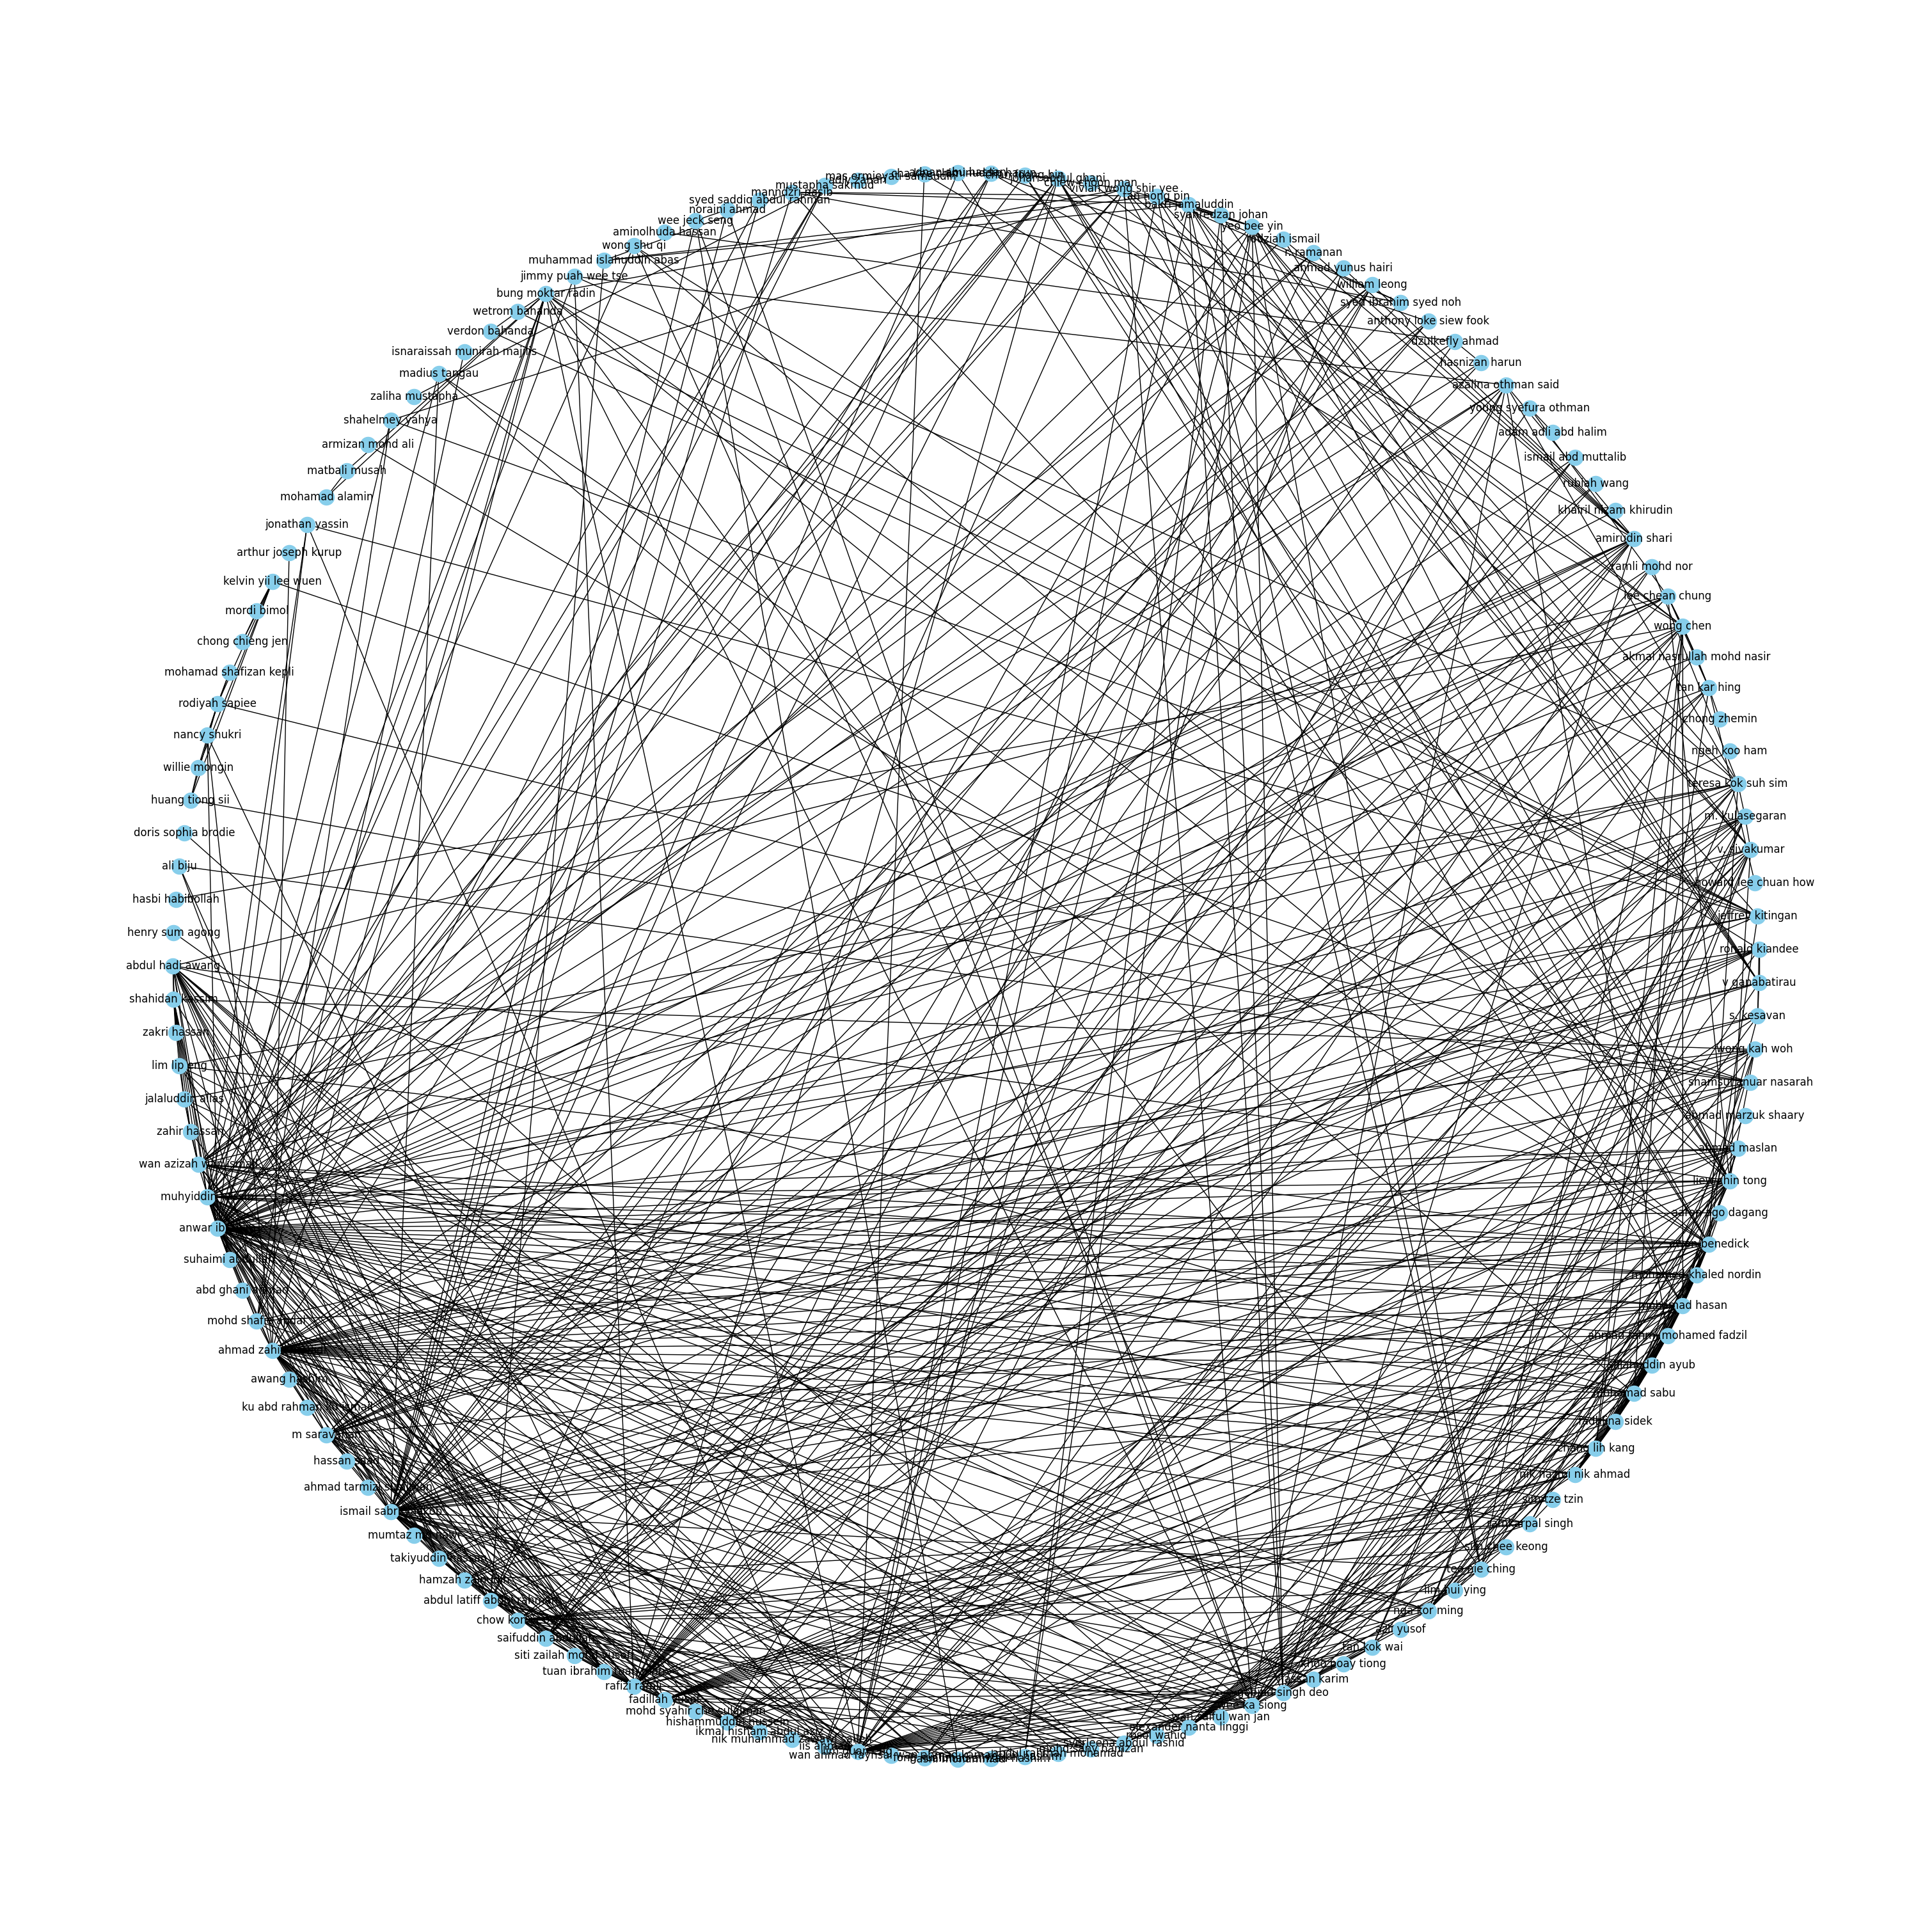

In [95]:
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-muted')
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df,
                            source="source",
                            target="target",
                            edge_attr="value",
                            create_using=nx.Graph())

plt.figure(figsize=(30,30))
pos = nx.shell_layout(G)
nx.draw(
    G,
    with_labels=True,
    node_color='skyblue',
    edge_cmap=plt.cm.Blues,
    pos=pos)
plt.show()

### Graph visualization - Pyvis

In [96]:
from pyvis.network import Network
net = Network(notebook=True,
                width="1800px",
                height="900px",
                bgcolor="#222222",
                font_color='white')

node_degree = dict(G.degree)

# setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')
net.from_nx(G)
net.repulsion(node_distance=100, spring_length=500)
net.show("output/20221209_MP_relationship.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### MPs' Communities

In [97]:
from community import community_louvain
# Louvain Community Detection Algorithm is a simple method to extract the community structure of a network.
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'group')
com_net = Network(notebook=True,
                    width="1800px",
                    height="900px",
                    bgcolor="#222222",
                    font_color='white')
com_net.from_nx(G)
com_net.repulsion(node_distance=300,
                    spring_length=100)
com_net.toggle_stabilization(True)
com_net.toggle_physics(True)
com_net.inherit_edge_colors(True)
com_net.show("output/20221209_MP_communities.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### The most important MP

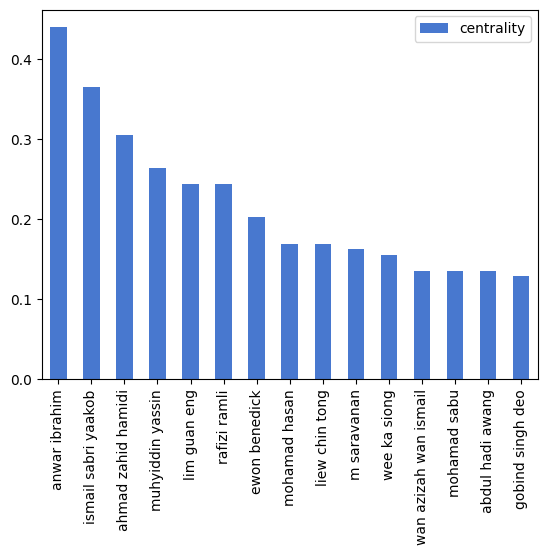

In [98]:
# Degree centrality : The degree centrality for a node is simply its degree.
degree_dict = nx.degree_centrality(G)
# save as attributes
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
degree_df = pd.DataFrame.from_dict(degree_dict,
                                    orient='index',
                                    columns=['centrality'])
# plot top 15
degree_df.sort_values('centrality',ascending=False)[:15].plot(kind='bar')
plt.show()

In [105]:
import networkx.algorithms.community as nx_com
W = nx.petersen_graph()
nx_com.louvain_communities(W, seed=100)
lcom_net = Network(notebook=True,
                    width="1800px",
                    height="900px",
                    bgcolor="#222222",
                    font_color='white')
lcom_net.from_nx(W)
lcom_net.repulsion(node_distance=300,
                    spring_length=100)
lcom_net.toggle_stabilization(True)
lcom_net.toggle_physics(True)
lcom_net.inherit_edge_colors(True)
lcom_net.show("output/20221209_MP_lcommunities.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### Most Important "Connectors"

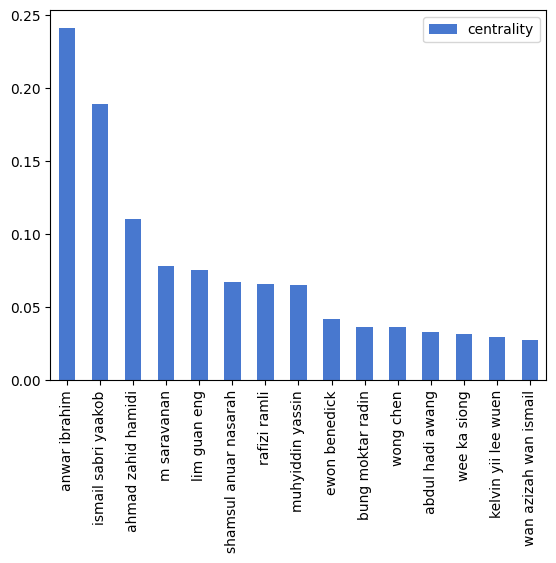

In [99]:
# Betweenness centrality is a widely used measure that captures a person's
# role in allowing information to pass from one part of the network to the other.
betweenness_dict = nx.betweenness_centrality(G)
# save as attribute
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
betweenness_df = pd.DataFrame.from_dict(betweenness_dict,
orient='index', columns=['centrality'])
# plot top 15
betweenness_df.sort_values('centrality', ascending=False)[:15].plot(kind='bar')
plt.show()

### Most closely connected MPs

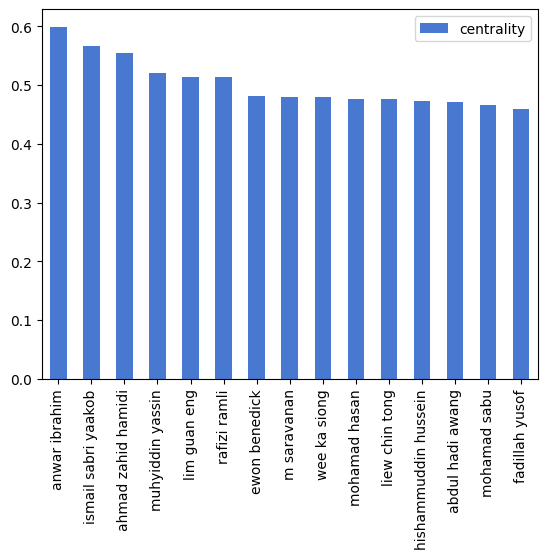

In [100]:
# closeness centrality : Closeness centrality indicates how close a node is to all other nodes in the network.
# It is calculated as the average of the shortest path length from the node to every other node in the network.
closeness_dict = nx.closeness_centrality(G)
# save as attribute
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# plot top 15
closeness_df.sort_values('centrality', ascending=False)[:15].plot(kind='bar')
plt.show()